In [1]:
# copy of poduv.m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import os
import io

np.set_printoptions(linewidth=150)
np.set_printoptions(precision=3)

In [2]:
def read_vec_file(fname):
    data = np.genfromtxt(fname, skip_header=1, delimiter=',',usecols=(0,1,2,3,4))
    r,c = np.unique(data[:,1]).shape[0],np.unique(data[:,0]).shape[0] # order ?
    
    x = data[:,0].reshape(r,c)
    y = data[:,1].reshape(r,c)
    u = data[:,2].reshape(r,c)
    v = data[:,3].reshape(r,c)
    chc = data[:,4].reshape(r,c)
    return x,y,u,v,chc

In [3]:
list_of_vec_files = glob('../../small_test/*.vec')
list_of_vec_files.sort()
list_of_vec_files

['../../small_test/06302014_2Hz_particles000200.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000201.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000202.T000.D000.P000.H000.L.vec',
 '../../small_test/06302014_2Hz_particles000203.T000.D000.P000.H000.L.vec']

In [63]:
u,v,chc = [],[],[]
for fname in list_of_vec_files:
    x,y,_u,_v,_chc = read_vec_file(fname)
    u.append(_u)
    v.append(_v)
    chc.append(_chc)

u = np.stack(u)
v = np.stack(v)
chc = np.stack(chc)

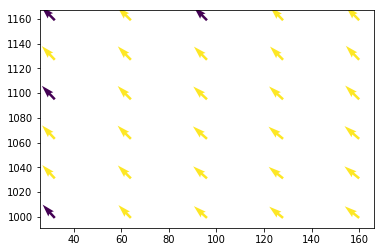

In [64]:
fig,ax = plt.subplots()
ax.quiver(x,y,u[0,:,:],v[0,:,:],chc[0,:,:])

In [6]:
method = 'snapshot'
n_modes = None

In [68]:
def pod_modes(u,v,n_modes=None, method='snapshot'):
    """ estimates POD modes of a 2D vector field using a direct or a snapshot methods """
    N = len(u)
    r,c = u[0].shape

    # read data and rearrange in columns
    len1 = r*c

    U = np.zeros((len1*2,N)) # r*c*3 length of the vector

    # stack [u,v] together in columns
    for i in range(N):
        U[:len1,i] = u[i,:,:].flatten()
        U[len1:,i] = v[i,:,:].flatten()

    # fluctuations
    Umean = np.mean(U,axis=1)
    Uf = U - Umean[:,np.newaxis]

    if method is 'snapshot': # small size as number of snapshots
        R = np.dot(Uf.T,Uf)  # R = Uf.T@Uf equivalent expression
    elif method is 'direct': # large size as size of the PIV map
        R = np.dot(Uf,Uf.T)  # or R  = Uf@Uf.T

    # print(R.shape)

    D,V = np.linalg.eigh(R)

    # check consistency 
    assert (np.abs(np.dot(R,V) - np.dot(V,np.diag(D))).max() < 1e-11)

    _ = D/N
    L = np.sort(_)
    I = np.argsort(_)

    L = L[::-1]
    I = I[::-1]

    Erel = np.cumsum(L/np.sum(L))
    plt.figure()
    plt.plot(Erel[:N]*100)

    # modes
    if n_modes is None:
        n_modes = np.min([N,D.shape[0]]) # all relevant
    if method is 'snapshot':
        S = np.sqrt(np.abs(D))
        S = S[I]
        V = V[:,I]
        a = np.diag(S[:n_modes])@V[:,:n_modes].T
        phi = Uf@V[:,:n_modes]@np.diag(1./S[:n_modes])
    elif method is 'direct':
        phi = V[:,I]
        a = np.dot(Uf.T,phi[:,:n_modes]).T
        phi = phi[:,:n_modes].real

    umodes,vmodes = np.zeros((r,c,n_modes),dtype=complex),np.zeros((r,c,n_modes),dtype=complex)
    for i in range(n_modes):
        umodes[:,:,i] = phi[:len1,i].reshape(r,c)
        vmodes[:,:,i] = phi[len1:,i].reshape(r,c)
    return umodes,vmodes

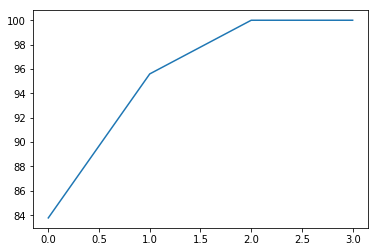

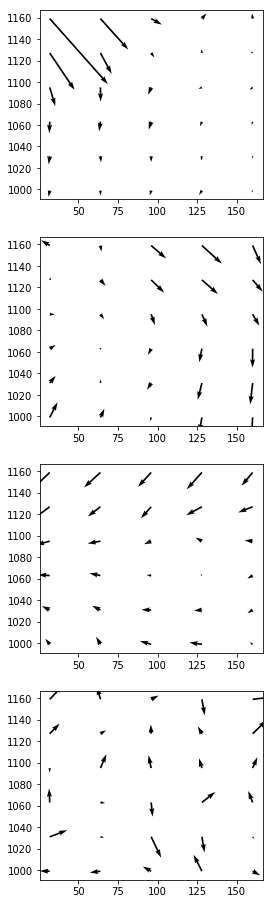

In [69]:
umodes,vmodes = pod_modes(u,v,n_modes=None, method='snapshot')

fig,ax = plt.subplots(4,1,figsize=(4,16))
for i in range(4):
    ax[i].quiver(X,Y,umodes[:,:,i],vmodes[:,:,i])

In [12]:
# umd,vmd = pod_modes(u,v,method='direct')
# ums,vms = pod_modes(u,v,method='snapshot')

In [13]:
tmp = [2.4818, 0.9322, 0.5691, 0.0000]

In [14]:
tmp

[2.4818, 0.9322, 0.5691, 0.0]

In [15]:
assert np.abs(tmp - S).max() < .2e-4 # why is it so inaccurate? 

In [16]:
V

array([[-0.386,  0.775, -0.027, -0.5  ],
       [ 0.569, -0.017,  0.652, -0.5  ],
       [ 0.413, -0.143, -0.748, -0.5  ],
       [-0.597, -0.615,  0.122, -0.5  ]])

In [17]:
_="""     0.3856   -0.7750    0.0267   -0.5000
   -0.5693    0.0169   -0.6524   -0.5000
   -0.4133    0.1427    0.7475   -0.5000
    0.5970    0.6154   -0.1218   -0.5000 """
V_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [18]:
V - (V_mat)

array([[-7.712e-01,  1.550e+00, -5.337e-02,  3.886e-16],
       [ 1.139e+00, -3.381e-02,  1.305e+00, -1.332e-15],
       [ 8.266e-01, -2.854e-01, -1.495e+00,  1.277e-15],
       [-1.194e+00, -1.231e+00,  2.436e-01, -5.551e-16]])

In [19]:
_ = """0.9569   -1.4128   -1.0258    1.4817
   -0.7225    0.0158    0.1330    0.5737
    0.0152   -0.3713    0.4254   -0.0693
   -0.0000   -0.0000   -0.0000   -0.0000
 """
a_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [20]:
a

array([[-9.569e-01,  1.413e+00,  1.026e+00, -1.482e+00],
       [ 7.225e-01, -1.577e-02, -1.330e-01, -5.737e-01],
       [-1.518e-02,  3.713e-01, -4.254e-01,  6.932e-02],
       [-8.598e-09, -8.598e-09, -8.598e-09, -8.598e-09]])

In [21]:
phi

array([[ 5.005e-01, -1.119e-01, -3.132e-01,  2.663e-08],
       [ 2.392e-01,  1.388e-02, -2.123e-01, -6.860e-09],
       [ 9.149e-02,  1.936e-01, -1.700e-01,  1.453e-08],
       [ 3.879e-02,  2.583e-01, -1.963e-01,  5.649e-09],
       [-5.289e-03,  1.086e-01, -1.430e-01,  3.793e-08],
       [ 2.139e-01,  1.879e-02, -2.164e-01,  1.937e-08],
       [ 9.689e-02,  6.752e-02, -1.622e-01,  1.090e-08],
       [ 2.757e-02,  1.681e-01, -1.328e-01, -8.071e-10],
       [-2.385e-03,  2.085e-01, -2.032e-01, -8.071e-09],
       [-1.739e-02,  1.311e-01, -1.869e-01,  2.744e-08],
       [ 4.800e-02,  6.607e-02, -1.791e-01,  0.000e+00],
       [ 1.442e-03,  4.846e-02, -1.656e-01,  1.170e-08],
       [-2.591e-02,  4.843e-02, -9.225e-02, -5.246e-09],
       [-2.999e-02,  7.105e-02, -8.197e-02, -5.649e-09],
       [-2.563e-02,  8.775e-02, -1.036e-01,  9.281e-09],
       [-3.322e-03,  7.759e-02, -1.505e-01, -1.211e-09],
       [-1.191e-02,  9.687e-03, -1.430e-01,  9.281e-09],
       [-2.061e-02, -4.135e-02,

In [22]:
_="""    -0.5005    0.1119    0.3132    0.0000
   -0.2139   -0.0188    0.2164    0.0000
   -0.0480   -0.0661    0.1791   -0.0000
    0.0033   -0.0776    0.1505   -0.0000
    0.0089   -0.0772    0.1021    0.0000
    0.0109   -0.1006    0.0572   -0.0000
   -0.2392   -0.0139    0.2123   -0.0000
   -0.0969   -0.0675    0.1622    0.0000
   -0.0014   -0.0485    0.1656    0.0000
    0.0119   -0.0097    0.1430    0.0000
   -0.0053   -0.0025    0.1080    0.0000
   -0.0000   -0.0514    0.0567   -0.0000
   -0.0915   -0.1936    0.1700    0.0000
   -0.0276   -0.1681    0.1328   -0.0000
    0.0259   -0.0484    0.0923   -0.0000
    0.0206    0.0413    0.0596   -0.0000
    0.0003    0.0544    0.1259    0.0000
    0.0118    0.0122    0.1465   -0.0000
   -0.0388   -0.2583    0.1963   -0.0000
    0.0024   -0.2085    0.2032   -0.0000
    0.0300   -0.0710    0.0820   -0.0000
    0.0167    0.0352    0.0193    0.0000
    0.0078    0.0543    0.1039   -0.0000
    0.0240    0.0359    0.1618   -0.0000
    0.0053   -0.1086    0.1430    0.0000
    0.0174   -0.1311    0.1869    0.0000
    0.0256   -0.0877    0.1036    0.0000
    0.0079    0.0007    0.0674   -0.0000
    0.0060    0.0308    0.0667   -0.0000
    0.0100    0.0157    0.0357    0.0000
    0.5630   -0.0689    0.3027    0.0000
    0.3174   -0.0331    0.1595    0.0000
    0.1610    0.0010    0.0486   -0.0000
    0.0984   -0.0475   -0.0113    0.0000
    0.0703   -0.0925   -0.0499    0.0000
    0.0542   -0.1965   -0.0712    0.0000
    0.2660    0.0787    0.1944    0.0000
    0.1792    0.0779    0.1245   -0.0000
    0.1224    0.0637    0.0296    0.0000
    0.0825   -0.0107   -0.0304    0.0000
    0.0534   -0.0445   -0.0534    0.0000
    0.0432   -0.1141   -0.0971    0.0000
    0.0515    0.1673    0.1862   -0.0000
    0.0383    0.1647    0.1480    0.0000
    0.0631    0.1385    0.0390    0.0000
    0.0680    0.0810   -0.0070   -0.0000
    0.0502    0.0871   -0.0031   -0.0000
    0.0430    0.0500   -0.0432    0.0000
   -0.0452    0.2344    0.2182   -0.0000
   -0.0318    0.1840    0.1083    0.0000
    0.0129    0.1590   -0.0466    0.0000
    0.0382    0.1766   -0.0200    0.0000
    0.0377    0.2168    0.0092   -0.0000
    0.0391    0.1963   -0.0234    0.0000
   -0.0454    0.2414    0.1722   -0.0000
   -0.0152    0.1531    0.0731    0.0000
    0.0222    0.1488   -0.0108    0.0000
    0.0265    0.2463    0.0398    0.0000
    0.0215    0.2761    0.0425   -0.0000
    0.0170    0.2649   -0.0281   -0.0000
    """
phi_mat = np.genfromtxt(io.BytesIO(_.encode()))

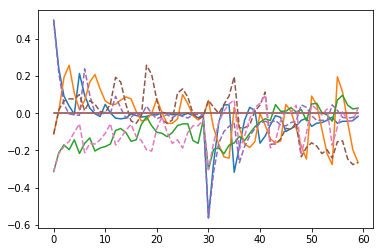

In [23]:
plt.figure()
plt.plot(phi)
plt.plot(-phi_mat,'--')

In [24]:
u[0,:,:]

array([[-2.419, -2.441, -2.372, -2.314, -2.376],
       [-2.371, -2.39 , -2.384, -2.385, -2.433],
       [-2.364, -2.412, -2.507, -2.559, -2.555],
       [-2.335, -2.428, -2.572, -2.663, -2.684],
       [-2.298, -2.385, -2.524, -2.632, -2.705],
       [-2.229, -2.274, -2.399, -2.527, -2.64 ]])

In [25]:
Uf[:,0]

array([-5.550e-01, -2.157e-01,  5.487e-02,  1.525e-01,  8.567e-02, -1.879e-01, -4.148e-02,  9.708e-02,  1.560e-01,  1.142e-01,  4.525e-03,
        3.615e-02,  6.119e-02,  8.127e-02,  8.949e-02,  6.152e-02,  2.056e-02, -9.248e-03, -9.167e-03,  8.059e-03,  6.584e-02, -1.664e-03,
       -3.712e-02, -3.021e-02, -1.551e-02,  8.397e-02,  3.794e-02,  4.710e-03, -5.415e-04, -1.177e-03,  5.932e-01,  2.006e-01, -6.877e-02,
       -2.093e-01, -2.152e-01,  3.300e-01,  1.171e-01, -8.011e-02, -1.617e-01, -1.241e-01,  1.541e-01,  7.155e-02, -3.908e-02, -1.032e-01,
       -8.648e-02,  1.283e-01,  8.624e-02,  6.445e-03, -9.132e-02, -1.520e-01,  1.334e-01,  8.247e-02, -1.494e-02, -1.204e-01, -1.782e-01,
        1.927e-01,  1.223e-01,  4.413e-03, -1.048e-01, -1.755e-01])

In [31]:
umodes[:,:,0].real

array([[ 5.005e-01,  2.392e-01,  9.149e-02,  3.879e-02, -5.289e-03],
       [ 2.139e-01,  9.689e-02,  2.757e-02, -2.385e-03, -1.739e-02],
       [ 4.800e-02,  1.442e-03, -2.591e-02, -2.999e-02, -2.563e-02],
       [-3.322e-03, -1.191e-02, -2.061e-02, -1.669e-02, -7.898e-03],
       [-8.928e-03,  5.323e-03, -2.530e-04, -7.787e-03, -5.992e-03],
       [-1.087e-02,  2.688e-05, -1.184e-02, -2.397e-02, -1.004e-02]])

In [27]:
_="""-0.5005   -0.2392   -0.0915   -0.0388    0.0053
   -0.2139   -0.0969   -0.0276    0.0024    0.0174
   -0.0480   -0.0014    0.0259    0.0300    0.0256
    0.0033    0.0119    0.0206    0.0167    0.0079
    0.0089   -0.0053    0.0003    0.0078    0.0060
    0.0109   -0.0000    0.0118    0.0240    0.0100"""
umodes_mat = np.genfromtxt(io.BytesIO(_.encode()))

In [28]:
umodes_mat

array([[-5.005e-01, -2.392e-01, -9.150e-02, -3.880e-02,  5.300e-03],
       [-2.139e-01, -9.690e-02, -2.760e-02,  2.400e-03,  1.740e-02],
       [-4.800e-02, -1.400e-03,  2.590e-02,  3.000e-02,  2.560e-02],
       [ 3.300e-03,  1.190e-02,  2.060e-02,  1.670e-02,  7.900e-03],
       [ 8.900e-03, -5.300e-03,  3.000e-04,  7.800e-03,  6.000e-03],
       [ 1.090e-02, -0.000e+00,  1.180e-02,  2.400e-02,  1.000e-02]])

In [41]:
np.allclose(np.abs((umodes[:,:,0].real*umodes_mat).sum(0)),1.)

False

In [44]:
np.abs((umodes[:,:,0].real*umodes_mat).sum(0))

array([0.299, 0.067, 0.01 , 0.003, 0.001])

In [46]:
umodes[:,:,0].real,umodes_mat

(array([[ 5.005e-01,  2.392e-01,  9.149e-02,  3.879e-02, -5.289e-03],
        [ 2.139e-01,  9.689e-02,  2.757e-02, -2.385e-03, -1.739e-02],
        [ 4.800e-02,  1.442e-03, -2.591e-02, -2.999e-02, -2.563e-02],
        [-3.322e-03, -1.191e-02, -2.061e-02, -1.669e-02, -7.898e-03],
        [-8.928e-03,  5.323e-03, -2.530e-04, -7.787e-03, -5.992e-03],
        [-1.087e-02,  2.688e-05, -1.184e-02, -2.397e-02, -1.004e-02]]),
 array([[-5.005e-01, -2.392e-01, -9.150e-02, -3.880e-02,  5.300e-03],
        [-2.139e-01, -9.690e-02, -2.760e-02,  2.400e-03,  1.740e-02],
        [-4.800e-02, -1.400e-03,  2.590e-02,  3.000e-02,  2.560e-02],
        [ 3.300e-03,  1.190e-02,  2.060e-02,  1.670e-02,  7.900e-03],
        [ 8.900e-03, -5.300e-03,  3.000e-04,  7.800e-03,  6.000e-03],
        [ 1.090e-02, -0.000e+00,  1.180e-02,  2.400e-02,  1.000e-02]]))

In [56]:
np.abs(np.dot(umodes[:,:,0].real.T,umodes_mat).sum(0)).sum()

0.8737565970468506

In [62]:
(umodes[:,:,0].real + umodes_mat).sum()

0.00010312106127388724